# Sample Mackenzie River box for SSS anomaly from ECCOv4r4

In [41]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41445")
client

<Client: 'tcp://127.0.0.1:41445' processes=4 threads=8, memory=61.46 GiB>

In [56]:
from os.path import join,expanduser
import sys
sys.path.insert(0,join(expanduser('~'),'ECCOv4-py'))
import ecco_v4_py.ecco_access as ea

In [57]:
import xarray as xr
import matplotlib.pyplot as plt

# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository, rather than the pre-installed older version
from os.path import join,expanduser
import sys
sys.path.insert(0,join(expanduser('~'),'ECCOv4-py'))

import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea

# identify user's home directory
user_home_dir = expanduser('~')

In [42]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import fsspec

In [3]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [4]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [5]:
# function for determining the memory footprint of an object

# ... from https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

## Open V4r4

In [59]:
#https://search.earthdata.nasa.gov/search/granules?p=C1991543742-POCLOUD
ShortName = 'ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4'

In [60]:
# search granules for a collection
response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.json", 
                            params={'ShortName':ShortName})
print( response.status_code)
response_json = response.json()['feed']['entry']

200


In [70]:
StartDate='1992-01-01'
EndDate  ='2014-12-31' 

In [71]:
# CMR can only return up to 2000 files
# so be careful about what you search for
input_search_params = {'ShortName' : ShortName,
                       'temporal'  : f"{StartDate} , {EndDate}",  
                       'page_size' :2000}

In [72]:
# search granules for a collection
response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.json", 
                            params=input_search_params)
print('CMR response code ', response.status_code)
response_json = response.json()['feed']['entry']
print(f'returned {len(response_json)} entries')

# 60 is < 2000, so we're good

CMR response code  200
returned 276 entries


In [73]:
s3_podaac_paths=[]
for rj in response_json:
    links = rj['links']
    for link in links:
        if 'title' in link.keys():
            if 'direct download access via S3' in link['title']:
                s3_podaac_paths.append(link['href'])
pprint(s3_podaac_paths)

['s3://podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-01_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-02_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-03_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-04_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-05_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-06_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_

In [85]:
s3, credentials = init_S3FileSystem(use_earthdata=True)

#### open multiple granules hosted on PO-CLOUD

In [ ]:
ns = [276]
time_ns = []

for n in ns:
    files_to_load = s3_podaac_paths[:n]

    start_time = time.time()

    # pre-open the files
    file_objects = [s3.open(p, mode='rb') for p in files_to_load]
    # load into memory
    multiple_granules = xr.open_mfdataset(file_objects, 
                                          parallel=True, data_vars='minimal',\
                                          coords='minimal',compat='override',
                                          combine='nested', concat_dim='time').load()
    
    total_time = time.time() - start_time

    print('\nloaded multiple granules')
    print(f'total time {total_time:.2f} sec for {len(multiple_granules.time.values)} granules')
    print(f'time per granule {total_time/len(files_to_load):.2f} sec/gran')
    
    time_ns.append(total_time)

In [83]:
sss_arctic = multiple_granules.SALT.sel(tile=7,k=0)

In [84]:
sss_arctic

<xarray.DataArray 'SALT' (time: 108, j: 90, i: 90)> Size: 3MB
array([[[      nan,       nan,       nan, ..., 34.491367, 34.356922,
         34.27136 ],
        [      nan,       nan,       nan, ..., 34.484753, 34.34838 ,
         34.26603 ],
        [      nan,       nan,       nan, ..., 34.47988 , 34.335606,
         34.252037],
        ...,
        [      nan,       nan,       nan, ..., 34.059456, 34.205082,
         34.343273],
        [      nan,       nan,       nan, ..., 34.038193, 34.184265,
         34.332485],
        [      nan,       nan,       nan, ..., 34.027103, 34.16508 ,
         34.318184]],

       [[      nan,       nan,       nan, ..., 34.409508, 34.329403,
         34.29949 ],
        [      nan,       nan,       nan, ..., 34.41185 , 34.321068,
         34.288963],
        [      nan,       nan,       nan, ..., 34.419216, 34.31409 ,
         34.275764],
...
        [      nan,       nan,       nan, ..., 33.9274  , 33.93534 ,
         33.98381 ],
        [      nan,       nan,       nan, ..., 33.89366 , 33.883434,
         33.942215],
        [      nan,       nan,       nan, ..., 33.86371 , 33.84217 ,
         33.909286]],

       [[      nan,       nan,       nan, ..., 34.36946 , 34.16631 ,
         34.00037 ],
        [      nan,       nan,       nan, ..., 34.399017, 34.197144,
         34.024498],
        [      nan,       nan,       nan, ..., 34.420025, 34.22583 ,
         34.052334],
        ...,
        [      nan,       nan,       nan, ..., 33.939175, 33.98422 ,
         34.083992],
        [      nan,       nan,       nan, ..., 33.918896, 33.967155,
         34.054195],
        [      nan,       nan,       nan, ..., 33.905163, 33.956055,
         34.025913]]], dtype=float32)
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
    k        int32 4B 0
    tile     int32 4B 7
  * time     (time) datetime64[ns] 864B 1992-01-16T18:00:00 ... 2000-12-16T12...
    XC       (j, i) float32 32kB 142.2 142.2 142.3 ... -128.5 -128.5 -128.5
    YC       (j, i) float32 32kB 67.47 67.34 67.16 66.97 ... 12.42 11.44 10.46
    Z        float32 4B -5.0
Attributes:
    long_name:              Salinity
    units:                  1e-3
    coverage_content_type:  modelResult
    standard_name:          sea_water_salinity
    valid_min:              17.106637954711914
    valid_max:              41.26802444458008
    comment:                Defined using CF convention 'Sea water salinity i...

## Option 1

In [50]:
mzz_local_directory = Path('/efs_ecco/mzz-jsons/MZZ_LLC0090GRID_DAILY')
# different prefixes on s3
# MZZ_day_mean_latlon
# MZZ_day_mean_native
# MZZ_mon_mean_latlon
# MZZ_mon_mean_native
# MZZ_snap_native

In [51]:
# show they are on the local disk 
np.sort(list(mzz_local_directory.glob('*json')))

array([PosixPath('/efs_ecco/mzz-jsons/MZZ_LLC0090GRID_DAILY/ECCO_L4_ATM_STATE_LLC0090GRID_DAILY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_LLC0090GRID_DAILY/ECCO_L4_BOLUS_LLC0090GRID_DAILY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_LLC0090GRID_DAILY/ECCO_L4_DENS_STRAT_PRESS_LLC0090GRID_DAILY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_LLC0090GRID_DAILY/ECCO_L4_FRESH_FLUX_LLC0090GRID_DAILY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_LLC0090GRID_DAILY/ECCO_L4_HEAT_FLUX_LLC0090GRID_DAILY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_LLC0090GRID_DAILY/ECCO_L4_MIXED_LAYER_DEPTH_LLC0090GRID_DAILY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_LLC0090GRID_DAILY/ECCO_L4_OBP_LLC0090GRID_DAILY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_LLC0090GRID_DAILY/ECCO_L4_OCEAN_3D_MOMENTUM_TEND_LLC0090GRID_DAILY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_LLC0090GRID_DAILY/ECCO_L4_OCEAN_3D_SALINITY_FLUX_LLC0090GRID_DAILY_

In [52]:
# MZZ files have been downloaded. 

# select the temperature/salinity dataset
mzz_local_file= mzz_local_directory / 'ECCO_L4_TEMP_SALINITY_LLC0090GRID_DAILY_V4R4.json'
print(mzz_local_file)

/efs_ecco/mzz-jsons/MZZ_LLC0090GRID_DAILY/ECCO_L4_TEMP_SALINITY_LLC0090GRID_DAILY_V4R4.json


In [ ]:
fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, 
                                      "key": credentials['accessKeyId'],
                                      "secret" : credentials['secretAccessKey'], 
                                      "token" : credentials['sessionToken']},
                                      skip_instance_cache=True)

fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

ds

In [ ]:
ds.SALT.isel(time=100,k=0,tile=0).plot();

In [25]:
ssh_shortname = "ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4"
access_mode = 's3_open_fsspec'
download_root_dir = join(user_home_dir,'efs_ecco','ECCO_V4r4_PODAAC')
jsons_root_dir = join(user_home_dir,'efs_ecco','mzz-jsons')

In [26]:
ssh_ds = ea.ecco_podaac_to_xrdataset(ssh_shortname,\
                                     StartDate='1992-01',EndDate='2017-12',\
                                     mode=access_mode,\
                                     download_root_dir=download_root_dir,\
                                     max_avail_frac=0.5,\
                                     jsons_root_dir=jsons_root_dir)

NameError: name 'ea' is not defined

In [89]:
drake_pt = ssh_ds.SSH.isel(i=88,j=60,tile=11)
antar_pt = ssh_ds.SSH.isel(i=6,j=70,tile=12)

In [92]:
d_ssh = (drake_pt-antar_pt)
d_ssh_anomaly = d_ssh - d_ssh.mean()

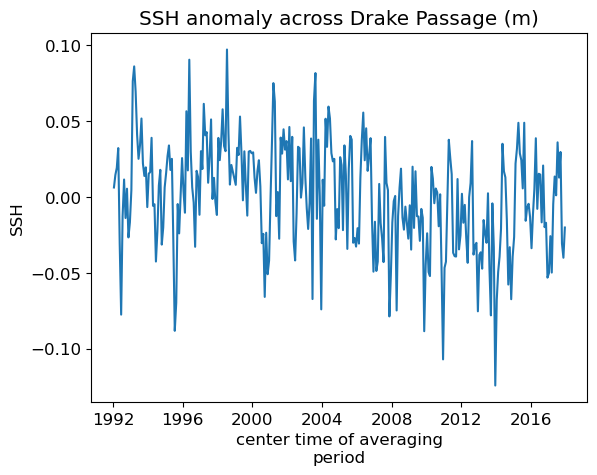

In [93]:
d_ssh_anomaly.plot();
plt.title("SSH anomaly across Drake Passage (m)");

## Option 2

### V4R4 FILES ON PODAAC

### Find files

Kerchunk files on ecco-model-granules s3 bucket

In [34]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);

In [35]:
mzz_local_directory = Path('/efs_ecco/mzz-jsons/MZZ_05DEG_MONTHLY')

In [36]:
# show they are on the local disk 
np.sort(list(mzz_local_directory.glob('*json')))

array([PosixPath('/efs_ecco/mzz-jsons/MZZ_05DEG_MONTHLY/ECCO_L4_ATM_STATE_05DEG_MONTHLY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_05DEG_MONTHLY/ECCO_L4_BOLUS_05DEG_MONTHLY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_05DEG_MONTHLY/ECCO_L4_DENS_STRAT_PRESS_05DEG_MONTHLY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_05DEG_MONTHLY/ECCO_L4_FRESH_FLUX_05DEG_MONTHLY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_05DEG_MONTHLY/ECCO_L4_HEAT_FLUX_05DEG_MONTHLY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_05DEG_MONTHLY/ECCO_L4_MIXED_LAYER_DEPTH_05DEG_MONTHLY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_05DEG_MONTHLY/ECCO_L4_OBP_05DEG_MONTHLY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_05DEG_MONTHLY/ECCO_L4_OCEAN_VEL_05DEG_MONTHLY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_05DEG_MONTHLY/ECCO_L4_SEA_ICE_CONC_THICKNESS_05DEG_MONTHLY_V4R4.json'),
       PosixPath('/efs_ecco/mzz-jsons/MZZ_05DEG_MONTHLY/ECCO_L4_SEA_ICE_

In [38]:
# MZZ files have been downloaded. 

# select the temperature/salinity dataset
mzz_local_file= mzz_local_directory / 'ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4.json'
print(mzz_local_file)

/efs_ecco/mzz-jsons/MZZ_05DEG_MONTHLY/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4.json


In [39]:
fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, 
                                      "key": credentials['accessKeyId'],
                                      "secret" : credentials['secretAccessKey'], 
                                      "token" : credentials['sessionToken']},
                                      skip_instance_cache=True)

fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

ds

<xarray.Dataset> Size: 32GB
Dimensions:         (time: 312, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 2kB 1992-01-16T18:00:00 ... 2017-12...
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
    time_bnds       (time, nv) datetime64[ns] 5kB dask.array<chunksize=(4, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, Z, latitude, longitude) float32 16GB dask.array<chunksize=(4, 50, 180, 360), meta=np.ndarray>
    THETA           (time, Z, latitude, longitude) float32 16GB dask.array<chunksize=(4, 50, 180, 360), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            7e05edde-4159-11eb-9ce1-0cc47a3f47f1

In [40]:
ds.SALT.isel(time=0,Z=0).values

Exception: ReferenceNotReachable()

In [20]:
lon_mg, lat_mg  = np.meshgrid(ds.longitude, ds.latitude)

In [ ]:
mean_SSS = ds.SALT.isel(Z=0).mean(dim='time').compute()

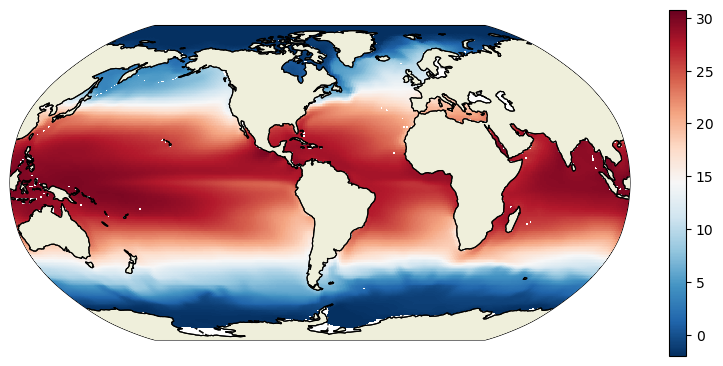

In [48]:
plt.figure(figsize=[10,4.5]);
ecco.plot_proj_to_latlon_grid(lon_mg, 
                              lat_mg, 
                              mean_SST, 
                              user_lon_0=-67, show_colorbar=True);

#  SOME CALCULATIONS: Select Box for ENSO comparison

In [49]:
lon_mg, lat_mg = np.meshgrid(ds.longitude, ds.latitude)

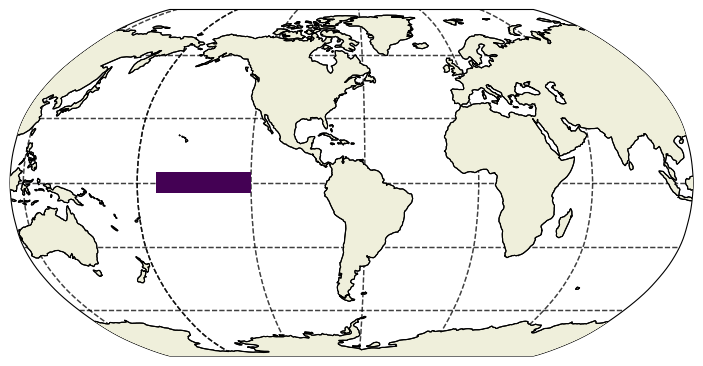

In [50]:
# Niño 3.4 (5N-5S, 170W-120W):  

# tweak as needed
box_lat = np.logical_and(mean_SST.latitude > -5, mean_SST.latitude < 5)
box_lon = np.logical_and(mean_SST.longitude > -170, mean_SST.longitude < -120)
box = np.logical_and(box_lat, box_lon)

# make mask, 1 in box, nan outside of box
mask = np.where(box, 1, np.nan)

# convert the mask into a data arraya
mask_DA = xr.DataArray(mask, dims=['latitude','longitude'],
                           coords={'latitude':ds.latitude,
                                   'longitude':ds.longitude})


# show box
plt.figure(figsize=[10,4.5]);
ecco.plot_proj_to_latlon_grid(lon_mg, 
                              lat_mg, 
                              mask_DA, 
                              user_lon_0=-67);

In [51]:
# calculate T mean in space (rough, assumes all horizontal grid cells are equal size)
st = time.time()

T_in_box = (ds.THETA*mask_DA).mean(dim=['latitude','longitude']).compute()

total_time = time.time() - st
# compute time with 4 workers on baby ec2 is 
print('total time to compute ', total_time)

total time to compute  48.93117141723633


In [52]:
print(ds.THETA.shape)
mem = 336*60*360*720*4
print(f'All of monthly-mean THETA in memory would require ~{mem/1e9} gb')

(336, 50, 360, 720)
All of monthly-mean THETA in memory would require ~20.901888 gb


In [53]:
# calculate the time mean of the the T_in_box
# operate on the intermediate field, T_in_box, rather than on ds.THETA
T_in_box_time_mean = T_in_box.mean(dim='time')

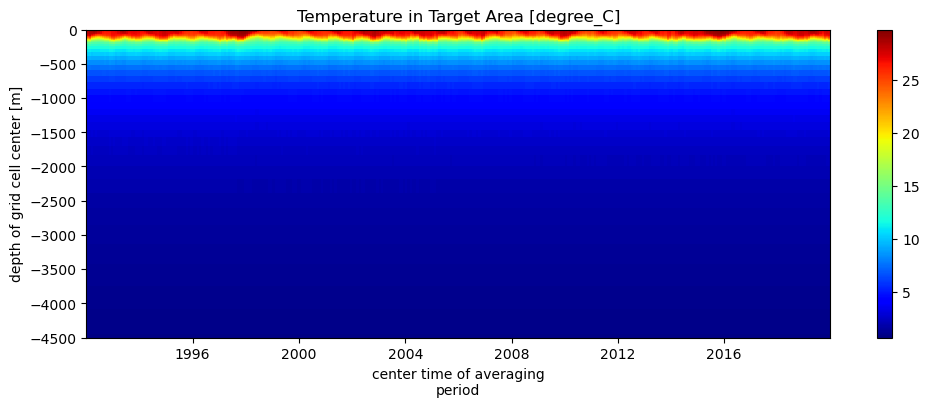

In [54]:
plt.figure(figsize=[12,4])
T_in_box.T.plot(cmap='jet')
plt.ylim([-4500, 0])
plt.title(f'Temperature in Target Area [{ds.THETA.attrs["units"]}]');

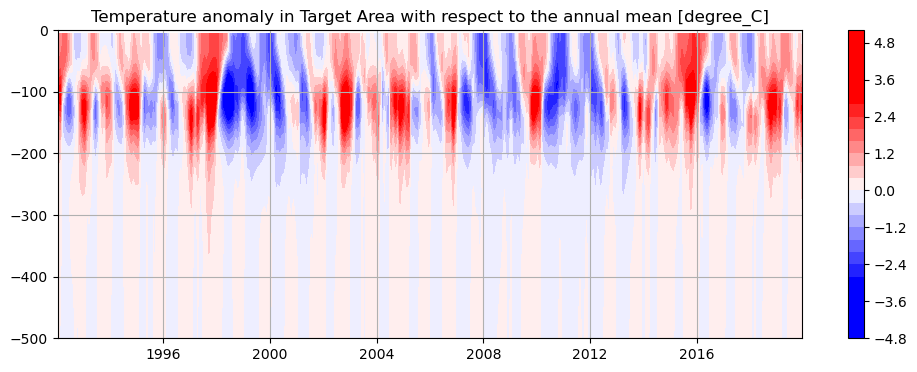

In [58]:
plt.figure(figsize=[12,4])
plt.contourf(T_in_box.time, T_in_box.Z, (T_in_box - T_in_box_time_mean).T, 30,
             cmap='bwr', vmin=-3, vmax=3);
plt.grid()
plt.colorbar()
plt.ylim([-500, 0])
plt.title(f'Temperature anomaly in Target Area with respect to the annual mean [{ds.THETA.attrs["units"]}]');

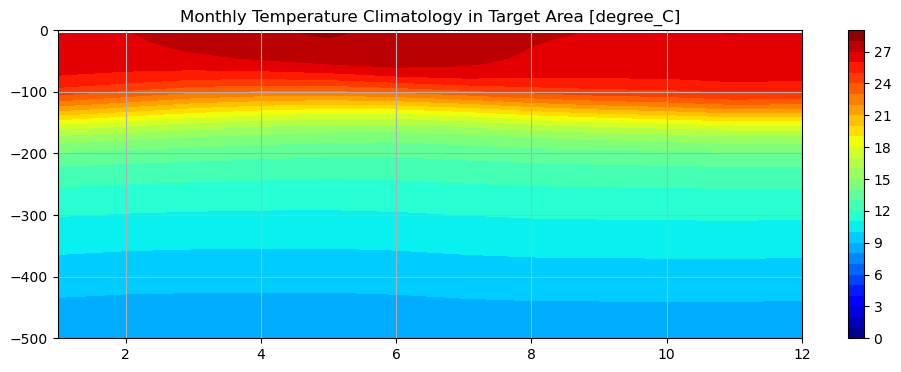

In [60]:
# Calculate monthly climatology
T_in_box_monthly_clim = T_in_box.groupby("time.month").mean()

plt.figure(figsize=[12,4])
plt.contourf(T_in_box_monthly_clim.month, T_in_box_monthly_clim.Z, T_in_box_monthly_clim.T, 
            30, cmap='jet')
plt.grid()
plt.colorbar()
plt.ylim([-500, 0])
plt.title(f'Monthly Temperature Climatology in Target Area [{ds.THETA.attrs["units"]}]');

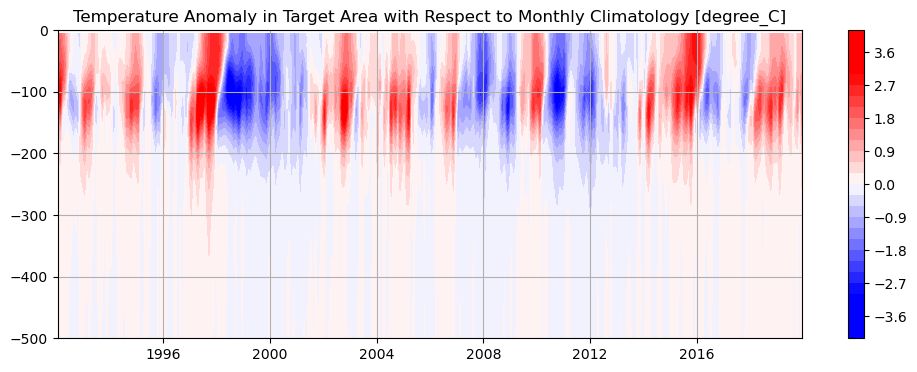

In [61]:
# Calculate anomaly with respect to the monthly climatology

T_in_box_anomaly = T_in_box.groupby('time.month')-T_in_box_monthly_clim


plt.figure(figsize=[12,4])
plt.contourf(T_in_box.time, T_in_box.Z, T_in_box_anomaly.T, 30,
             cmap='bwr', vmin=-3, vmax=3);
plt.grid()
plt.colorbar()
plt.ylim([-500, 0])
plt.title(f'Temperature Anomaly in Target Area with Respect to Monthly Climatology [{ds.THETA.attrs["units"]}]');